In [1]:
import os 
import tensorflow as tf

import numpy as np
import jax
import jax.numpy as jnp
import scipy
import matplotlib.pyplot as plt
from IPython.display import Audio

import flax
from flax import linen as nn
from flax.training import train_state 
import optax

from audax.core import functional
from functools import partial

import dsp_functions as DSP
import jax_functions as jax_funcs
import librosa
import importlib
importlib.reload(DSP)
importlib.reload(jax_funcs)

rng = jax.random.PRNGKey(420) 

SR = 16000
SECONDS = 4
# Ensure TF does not see GPU and grab all GPU memory.
tf.config.set_visible_devices([], device_type='GPU')
filenames = ["data/violin_solo/"+i for i in os.listdir("data/violin_solo/")]

2023-04-18 13:35:30.587664: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# load the database

In [2]:
# Create a description of the features.
feature_description = {
        'audio':tf.io.FixedLenFeature([64000], dtype=tf.float32),
        'f0_hz':tf.io.FixedLenFeature([1000], dtype=tf.float32),
        'f0_confidence':tf.io.FixedLenFeature([1000], dtype=tf.float32),
        'loudness_db':tf.io.FixedLenFeature([1000], dtype=tf.float32),
    }

def _parse_function(example_proto):
  # Parse the input `tf.train.Example` proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)
dataset = tf.data.TFRecordDataset(filenames)
parsed_dataset = dataset.map(_parse_function)
z =  list(parsed_dataset.as_numpy_iterator())

In [8]:
idx = np.random.randint(len(z))
# idx = 149
print(idx)
sample = z[idx]
audio = sample["audio"][0:16000]
f0 = sample["f0_hz"][0:250]
amp = sample["loudness_db"][0:250]
envelope = amp/amp.min()
envelope = jax.image.resize(envelope,[SR],"linear")
Audio(audio,rate=SR,autoplay=True)


111


# multi level spectrograms
- the paper uses multiple NFFT sizes 

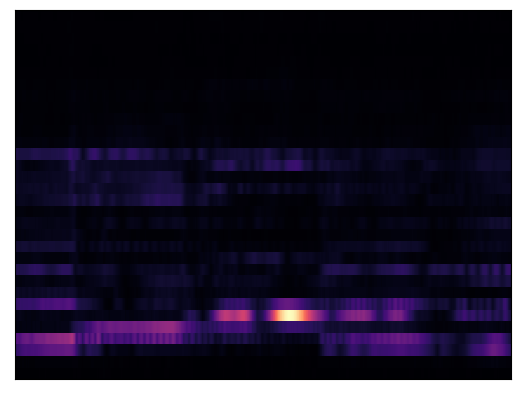

In [98]:
NFFTs = [512,1024,2048,4096] 

def return_mel_spec(NFFT):
    WIN_LEN = 400
    HOP_LEN = 20
    window = jnp.hanning(WIN_LEN)
    spec_func = partial(functional.spectrogram, pad=0, window=window, n_fft=NFFT,
                       hop_length=HOP_LEN, win_length=WIN_LEN, power=1,
                       normalized=False, center=False, onesided=True)
    fb = functional.melscale_fbanks(n_freqs=(NFFT//2)+1, n_mels=32,
                             sample_rate=SR, f_min=60., f_max=SR//2)
    mel_spec_func = partial(functional.apply_melscale, melscale_filterbank=fb)

    jax_spec = jax.jit(spec_func)
    mel_spec = jax.jit(mel_spec_func) 
    return mel_spec,jax_spec 

spec_funs = [return_mel_spec(x) for x in NFFTs]
spectrogram = spec_funs [-1][0](spec_funs[-1][1]((audio)))
librosa.display.specshow(spectrogram[0].T)